In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

2025-10-24 10:22:15.595383: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-24 10:22:16.001567: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-24 10:22:18.962161: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [7]:
n_epochs = 30  
n_layers = 1  
n_train = 50  
n_test = 30    

SAVE_PATH = "/media/godseye/Local Disk/College/College/Quantum Computing/Quantum-Machine-Learning/" 
PREPROCESS = True          
np.random.seed(0)           
tf.random.set_seed(0)       

In [8]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

train_images = train_images / 255
test_images = test_images / 255

train_images = np.array(train_images[..., tf.newaxis])
test_images = np.array(test_images[..., tf.newaxis])

(<Figure size 500x500 with 1 Axes>, <Axes: >)

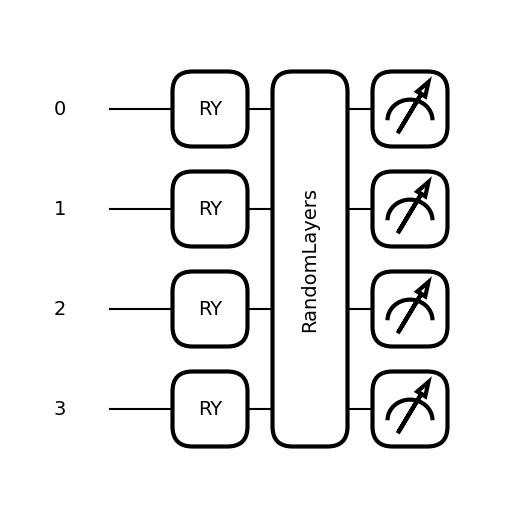

In [9]:
dev = qml.device("default.qubit", wires=4)
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)
    RandomLayers(rand_params, wires=list(range(4)))

    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

qml.draw_mpl(circuit)([np.pi, np.pi/2, np.pi/4, 2*np.pi])

In [10]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    for j in range(0, 28, 2):
        for k in range(0, 28, 2):

            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )

            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [11]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)

q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")


Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


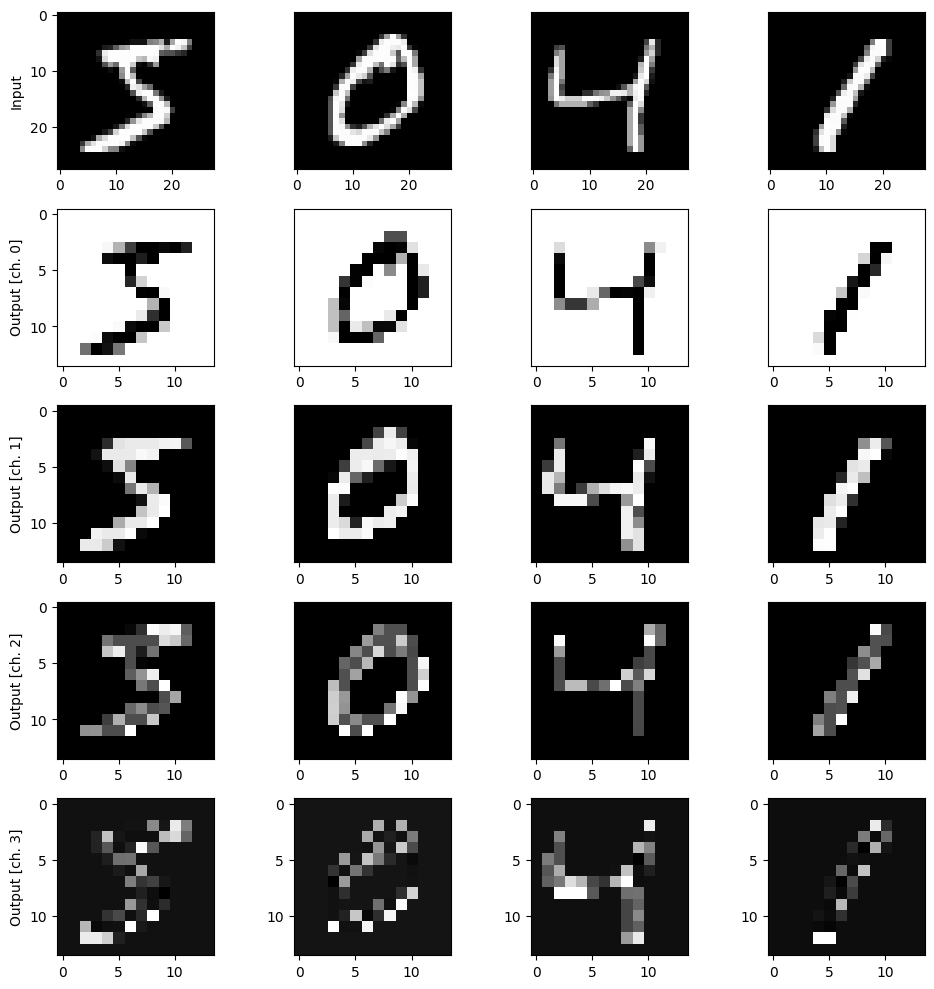

In [12]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [13]:
def MyModel():
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [15]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30


2025-10-24 12:44:00.019475: W tensorflow/core/framework/op_kernel.cc:1855] OP_REQUIRES failed at xla_ops.cc:590 : UNAVAILABLE: No PTX compilation provider is available. Neither ptxas/nvlink nor nvjtlink is available. As a fallback you can enable JIT compilation in the CUDA driver via the flag `--xla_gpu_unsafe_fallback_to_driver_on_ptxas_not_found`. Details: 
 - Has NvJitLink support: LibNvJitLink is not supported (disabled during compilation).
 - Has NvPtxCompiler support: LibNvPtxCompiler is not supported (disabled during compilation).
 - Parallel compilation support is desired: 0
 - ptxas_path: Couldn't find a suitable version of ptxas. The following locations were considered: ./cuda_sdk_lib/bin/ptxas, /usr/bin/ptxas, /home/godseye/.local/bin/ptxas, /home/godseye/.local/bin/ptxas, /usr/local/sbin/ptxas, /usr/local/bin/ptxas, /usr/sbin/ptxas, /usr/bin/ptxas, /sbin/ptxas, /bin/ptxas, /usr/games/ptxas, /usr/local/games/ptxas, /snap/bin/ptxas, /snap/bin/ptxas, /home/godseye/.local/bin/p

UnavailableError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/godseye/.local/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/godseye/.local/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/godseye/.local/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 758, in start

  File "/home/godseye/.local/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/godseye/.local/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 701, in shell_main

  File "/home/godseye/.local/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 469, in dispatch_shell

  File "/home/godseye/.local/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 379, in execute_request

  File "/home/godseye/.local/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 899, in execute_request

  File "/home/godseye/.local/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 471, in do_execute

  File "/home/godseye/.local/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 632, in run_cell

  File "/home/godseye/.local/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3116, in run_cell

  File "/home/godseye/.local/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3171, in _run_cell

  File "/home/godseye/.local/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/godseye/.local/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3394, in run_cell_async

  File "/home/godseye/.local/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3639, in run_ast_nodes

  File "/home/godseye/.local/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code

  File "/tmp/ipykernel_6697/1720861281.py", line 3, in <module>

  File "/home/godseye/.local/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/godseye/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/home/godseye/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/home/godseye/.local/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

No PTX compilation provider is available. Neither ptxas/nvlink nor nvjtlink is available. As a fallback you can enable JIT compilation in the CUDA driver via the flag `--xla_gpu_unsafe_fallback_to_driver_on_ptxas_not_found`. Details: 
 - Has NvJitLink support: LibNvJitLink is not supported (disabled during compilation).
 - Has NvPtxCompiler support: LibNvPtxCompiler is not supported (disabled during compilation).
 - Parallel compilation support is desired: 0
 - ptxas_path: Couldn't find a suitable version of ptxas. The following locations were considered: ./cuda_sdk_lib/bin/ptxas, /usr/bin/ptxas, /home/godseye/.local/bin/ptxas, /home/godseye/.local/bin/ptxas, /usr/local/sbin/ptxas, /usr/local/bin/ptxas, /usr/sbin/ptxas, /usr/bin/ptxas, /sbin/ptxas, /bin/ptxas, /usr/games/ptxas, /usr/local/games/ptxas, /snap/bin/ptxas, /snap/bin/ptxas, /home/godseye/.local/bin/ptxas, /home/godseye/.local/bin/ptxas, /usr/local/sbin/ptxas, /usr/local/bin/ptxas, /usr/sbin/ptxas, /usr/bin/ptxas, /sbin/ptxas, /bin/ptxas, /usr/games/ptxas, /usr/local/games/ptxas, /snap/bin/ptxas, /snap/bin/ptxas, ipykernel_launcher.runfiles/cuda_nvcc/bin/ptxas, ipykernel_launcher.runfiles/cuda_nvdisasm/bin/ptxas, ipykernel_launcher.runfiles/nvidia_nvshmem/bin/ptxas, ipykern/cuda_nvcc/bin/ptxas, ipykern/cuda_nvdisasm/bin/ptxas, ipykern/nvidia_nvshmem/bin/ptxas, bin/ptxas, /usr/local/cuda/bin/ptxas, /opt/cuda/bin/ptxas, /home/godseye/.local/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc/bin/ptxas, /home/godseye/.local/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc/bin/ptxas, /home/godseye/.local/lib/python3.12/site-packages/tensorflow/python/platform/../../cuda/bin/ptxas, /home/godseye/.local/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../bin/ptxas, /home/godseye/.local/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../../bin/ptxas
 - ptxas_version: Couldn't find a suitable version of ptxas. The following locations were considered: ./cuda_sdk_lib/bin/ptxas, /usr/bin/ptxas, /home/godseye/.local/bin/ptxas, /home/godseye/.local/bin/ptxas, /usr/local/sbin/ptxas, /usr/local/bin/ptxas, /usr/sbin/ptxas, /usr/bin/ptxas, /sbin/ptxas, /bin/ptxas, /usr/games/ptxas, /usr/local/games/ptxas, /snap/bin/ptxas, /snap/bin/ptxas, /home/godseye/.local/bin/ptxas, /home/godseye/.local/bin/ptxas, /usr/local/sbin/ptxas, /usr/local/bin/ptxas, /usr/sbin/ptxas, /usr/bin/ptxas, /sbin/ptxas, /bin/ptxas, /usr/games/ptxas, /usr/local/games/ptxas, /snap/bin/ptxas, /snap/bin/ptxas, ipykernel_launcher.runfiles/cuda_nvcc/bin/ptxas, ipykernel_launcher.runfiles/cuda_nvdisasm/bin/ptxas, ipykernel_launcher.runfiles/nvidia_nvshmem/bin/ptxas, ipykern/cuda_nvcc/bin/ptxas, ipykern/cuda_nvdisasm/bin/ptxas, ipykern/nvidia_nvshmem/bin/ptxas, bin/ptxas, /usr/local/cuda/bin/ptxas, /opt/cuda/bin/ptxas, /home/godseye/.local/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc/bin/ptxas, /home/godseye/.local/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc/bin/ptxas, /home/godseye/.local/lib/python3.12/site-packages/tensorflow/python/platform/../../cuda/bin/ptxas, /home/godseye/.local/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../bin/ptxas, /home/godseye/.local/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../../bin/ptxas
 - nvlink_path: Couldn't find a suitable version of nvlink. The following locations were considered: ./cuda_sdk_lib/bin/nvlink, /usr/bin/nvlink, /home/godseye/.local/bin/nvlink, /home/godseye/.local/bin/nvlink, /usr/local/sbin/nvlink, /usr/local/bin/nvlink, /usr/sbin/nvlink, /usr/bin/nvlink, /sbin/nvlink, /bin/nvlink, /usr/games/nvlink, /usr/local/games/nvlink, /snap/bin/nvlink, /snap/bin/nvlink, /home/godseye/.local/bin/nvlink, /home/godseye/.local/bin/nvlink, /usr/local/sbin/nvlink, /usr/local/bin/nvlink, /usr/sbin/nvlink, /usr/bin/nvlink, /sbin/nvlink, /bin/nvlink, /usr/games/nvlink, /usr/local/games/nvlink, /snap/bin/nvlink, /snap/bin/nvlink, ipykernel_launcher.runfiles/cuda_nvcc/bin/nvlink, ipykernel_launcher.runfiles/cuda_nvdisasm/bin/nvlink, ipykernel_launcher.runfiles/nvidia_nvshmem/bin/nvlink, ipykern/cuda_nvcc/bin/nvlink, ipykern/cuda_nvdisasm/bin/nvlink, ipykern/nvidia_nvshmem/bin/nvlink, bin/nvlink, /usr/local/cuda/bin/nvlink, /opt/cuda/bin/nvlink, /home/godseye/.local/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc/bin/nvlink, /home/godseye/.local/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc/bin/nvlink, /home/godseye/.local/lib/python3.12/site-packages/tensorflow/python/platform/../../cuda/bin/nvlink, /home/godseye/.local/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../bin/nvlink, /home/godseye/.local/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../../bin/nvlink
 - nvlink_version: Couldn't find a suitable version of nvlink. The following locations were considered: ./cuda_sdk_lib/bin/nvlink, /usr/bin/nvlink, /home/godseye/.local/bin/nvlink, /home/godseye/.local/bin/nvlink, /usr/local/sbin/nvlink, /usr/local/bin/nvlink, /usr/sbin/nvlink, /usr/bin/nvlink, /sbin/nvlink, /bin/nvlink, /usr/games/nvlink, /usr/local/games/nvlink, /snap/bin/nvlink, /snap/bin/nvlink, /home/godseye/.local/bin/nvlink, /home/godseye/.local/bin/nvlink, /usr/local/sbin/nvlink, /usr/local/bin/nvlink, /usr/sbin/nvlink, /usr/bin/nvlink, /sbin/nvlink, /bin/nvlink, /usr/games/nvlink, /usr/local/games/nvlink, /snap/bin/nvlink, /snap/bin/nvlink, ipykernel_launcher.runfiles/cuda_nvcc/bin/nvlink, ipykernel_launcher.runfiles/cuda_nvdisasm/bin/nvlink, ipykernel_launcher.runfiles/nvidia_nvshmem/bin/nvlink, ipykern/cuda_nvcc/bin/nvlink, ipykern/cuda_nvdisasm/bin/nvlink, ipykern/nvidia_nvshmem/bin/nvlink, bin/nvlink, /usr/local/cuda/bin/nvlink, /opt/cuda/bin/nvlink, /home/godseye/.local/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc/bin/nvlink, /home/godseye/.local/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc/bin/nvlink, /home/godseye/.local/lib/python3.12/site-packages/tensorflow/python/platform/../../cuda/bin/nvlink, /home/godseye/.local/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../bin/nvlink, /home/godseye/.local/lib/python3.12/site-packages/tensorflow/python/platform/../../../../../../../bin/nvlink
 - Driver compilation is enabled: 0

	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_1478]

In [ ]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 74ms/step - accuracy: 0.1000 - loss: 2.3877 - val_accuracy: 0.3000 - val_loss: 2.1918
Epoch 2/30
13/13 - 0s - 9ms/step - accuracy: 0.3400 - loss: 1.9843 - val_accuracy: 0.3333 - val_loss: 2.0515
Epoch 3/30
13/13 - 0s - 10ms/step - accuracy: 0.5400 - loss: 1.6984 - val_accuracy: 0.4667 - val_loss: 1.9168
Epoch 4/30
13/13 - 0s - 9ms/step - accuracy: 0.7400 - loss: 1.4577 - val_accuracy: 0.5000 - val_loss: 1.7905
Epoch 5/30
13/13 - 0s - 10ms/step - accuracy: 0.8400 - loss: 1.2545 - val_accuracy: 0.5000 - val_loss: 1.6800
Epoch 6/30
13/13 - 0s - 9ms/step - accuracy: 0.8600 - loss: 1.0852 - val_accuracy: 0.5000 - val_loss: 1.5876
Epoch 7/30
13/13 - 0s - 10ms/step - accuracy: 0.8800 - loss: 0.9454 - val_accuracy: 0.5333 - val_loss: 1.5115
Epoch 8/30
13/13 - 0s - 9ms/step - accuracy: 0.9000 - loss: 0.8295 - val_accuracy: 0.5667 - val_loss: 1.4487
Epoch 9/30
13/13 - 0s - 10ms/step - accuracy: 0.9600 - loss: 0.7329 - val_accuracy: 0.6000 - val_loss: 1.3961
Epoch 10/30
13

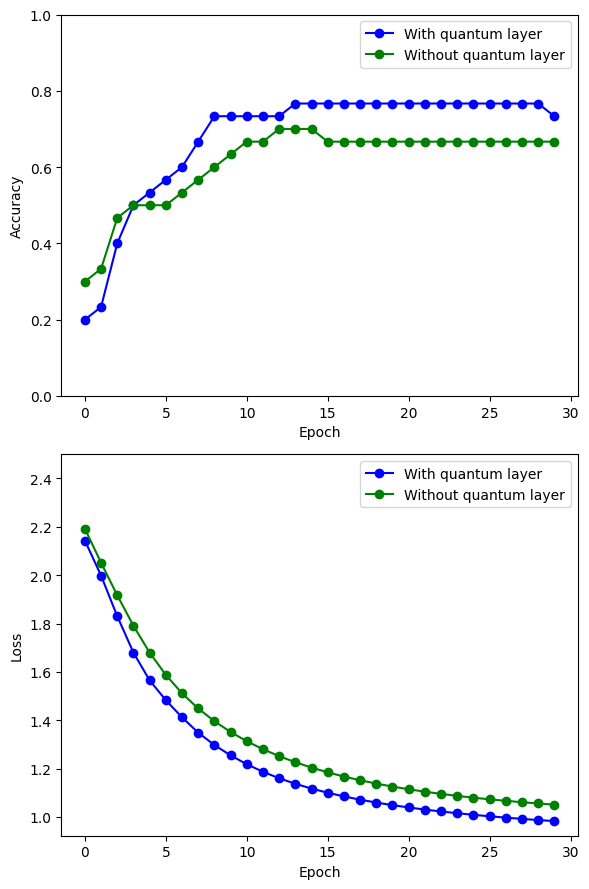

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()